### train mnist

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    #model = Net().to(device)
    model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model

m1 = main()

In [2]:
m1 = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370431
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.263697
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.070587
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.118050
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.216900

Test set: Average loss: 1.8910, Accuracy: 4984/10000 (50%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.126256
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.062810
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.063501
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.100083
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.033581

Test set: Average loss: 0.1066, Accuracy: 9665/10000 (97%)



### how's our model

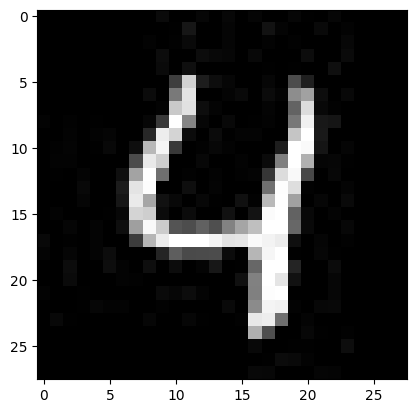

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [4]:

def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval():
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

cnn_eval(norm(four_tensor))

tensor(4)


### attack 

0 -0.0004107108688913286
10 -6.4222493171691895
20 -4.126559257507324
30 -4.981829643249512
40 -0.06205803155899048
True class probability: tensor([[1.7926e-03, 2.3122e-04, 3.1623e-04, 7.1983e-03, 9.3090e-03, 9.4490e-01,
         2.8435e-02, 2.0659e-04, 1.6093e-03, 6.0061e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


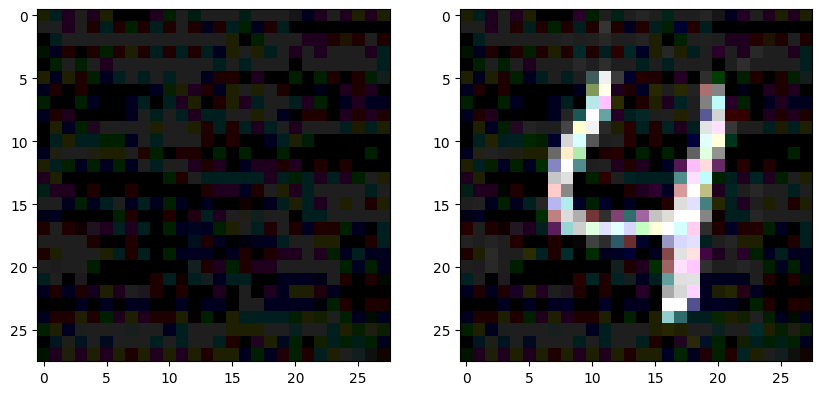

In [6]:
import torch.optim as optim


def l_infinity_pgd(model, tensor, gt,epsilon=30./255, target=None,iter=50, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=10)

    for t in range(iter):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:
            loss = loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
            + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 10 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(m1,four_tensor,4)

## targeted 

tensor(7)


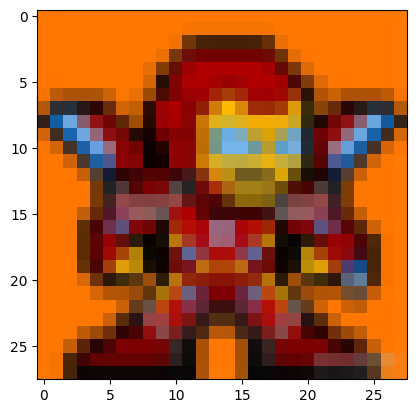

In [7]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


0 -7.384973049163818
10 -15.641661643981934
20 -4.557441711425781
30 -8.071575164794922
40 -8.202035903930664
50 -11.473377227783203
60 -9.415842056274414
70 -10.187394142150879
80 -5.133678436279297
90 -8.941489219665527
100 -9.489057540893555
110 -6.621605396270752
120 -12.040003776550293
130 -11.102195739746094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


140 -13.178126335144043
True class probability: tensor([[8.8448e-05, 1.7945e-04, 3.1686e-05, 1.8071e-05, 2.5772e-05, 7.6975e-05,
         1.0489e-03, 6.7718e-07, 9.9851e-01, 2.3812e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 1.0745,  1.0784,  1.0784,  ...,  1.0784,  1.0784,  1.0745],
          [ 1.0784,  1.0784,  1.0784,  ...,  1.0784,  1.0784,  0.9216],
          [ 0.9216,  0.9216,  1.0784,  ...,  0.9216,  1.0784,  1.0294],
          ...,
          [ 0.9216,  0.9098,  0.6941,  ...,  0.7059,  1.0667,  0.9216],
          [ 0.9216,  0.9180,  0.2157,  ...,  0.3412,  0.8235,  1.0390],
          [ 1.0745,  1.0392,  0.3569,  ...,  0.4196,  1.0007,  0.8980]],

         [[ 0.3922,  0.3882,  0.3882,  ...,  0.3882,  0.3882,  0.5529],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.5451,  0.3882,  0.5529],
          [ 0.3882,  0.5451,  0.5451,  ...,  0.5451,  0.5451,  0.5529],
          ...,
          [ 0.5451,  0.3843,  0.4510,  ...,  0.4549,  0.3843,  0.3961],
          [ 0.4565,  0.3725,  0.0667,  ...,  0.3882,  0.4627,  0.4196],
          [ 0.3961,  0.5373,  0.0667,  ...,  0.2941,  0.4196,  0.4118]],

         [[ 0.0863, -0.0745,  0.0824,  ...,  0.0824,  0.0824, -0.0627],
          [ 0.0824,  0.0824,  

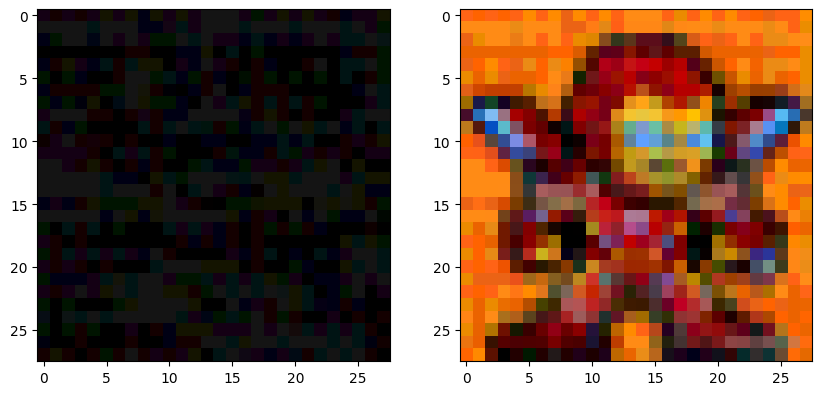

In [9]:

import torch.optim as optim

l_infinity_pgd(m1,rem_tensor,7,20./255,6,150)

### 生成对抗数据

In [10]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

0 -7.86750388215296e-05
10 -8.11782301752828e-05
20 -8.40390202938579e-05
30 -8.701899787411094e-05
40 -9.011816291604191e-05
True class probability: tensor([[5.4204e-07, 9.9991e-01, 2.9052e-05, 3.9524e-07, 2.1638e-05, 2.6021e-07,
         5.0005e-06, 3.0928e-05, 4.7572e-06, 4.5383e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(1)
0 -0.00262214383110404
10 -3.4314966201782227
20 -3.9307186603546143
30 -4.275073528289795
40 -4.288104057312012
True class probability: tensor([[2.3723e-05, 2.0860e-03, 1.8007e-03, 8.1972e-01, 5.4976e-04, 3.1066e-02,
         1.3769e-05, 1.3184e-02, 3.6579e-02, 9.4977e-02]],
       grad_fn=<SoftmaxBackward0>)
tensor(3)
0 -0.0003644755925051868
10 -0.00045170116936787963
20 -0.0005969410995021462
30 -0.000927137560211122
40 -0.0020093980710953474
True class probability: tensor([[9.9986e-06, 2.9638e-06, 1.7037e-07, 1.3323e-02, 4.3140e-07, 9.8562e-01,
         2.8624e-05, 9.1058e-06, 4.3271e-06, 1.0055e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor(5)
0 -0.

### 看看模型

In [11]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)




Test set: Average loss: 0.0369, Accuracy: 9871/10000 (99%)


Test set: Average loss: 0.6529, Accuracy: 1302/1713 (76%)


Test set: Average loss: 0.1066, Accuracy: 9665/10000 (97%)


Test set: Average loss: 0.3581, Accuracy: 1526/1713 (89%)

